# Enron ML Project
***by Bruno de Assis Pereira***

---
In this project, I am going to present a development process of a **Machine Learning** project and I am going to use the [**Enron Dataset**](https://www.kaggle.com/wcukierski/enron-email-dataset).

This dataset contains emails generated by employees of the Enron Corporation and some informations related to finances. The Enron was involved in a huge fraude.

The goal here is to be able to identify **Persons of Interest (*POI*)**.

In [406]:
#!/usr/bin/python
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import pickle
sys.path.append("../tools/")

import pandas as pd
import numpy as np
import math
from IPython.display import display
from itertools import combinations

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
### Storing data in a dataframe to simplify data manipulation
enron_df = pd.DataFrame.from_dict(data_dict, orient='index')
display(enron_df.head(2))
enron_df.info()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null object
to_messages                  146 non-null object
deferral_payments            146 non-null object
total_payments               146 non-null object
exercised_stock_options      146 non-null object
bonus                        146 non-null object
restricted_stock             146 non-null object
shared_receipt_with_poi      146 non-null object
restricted_stock_deferred    146 non-null object
total_stock_value            146 non-null object
expenses                     146 non-null object
loan_advances                146 non-null object
from_messages                146 non-null object
other                        146 non-null object
from_this_person_to_poi      146 non-null object
poi                          146 non-null bool
director_fees                146 non-null object
deferred_income              146 non-null object


---
### Looking for *Outliers*

---

In [407]:
def generate_scatter_plot(x, y, ax):
    enron_df.plot(
        kind='scatter',
        x=x,
        y=y,
        ax=ax
    )
    
    enron_df[enron_df['poi'] == True].plot(
        kind='scatter',
        x=x,
        y=y,
        color='r',
        marker='*',
        ax=ax
    )
    
    ax.set_title('{} X {}'.format(y,x))

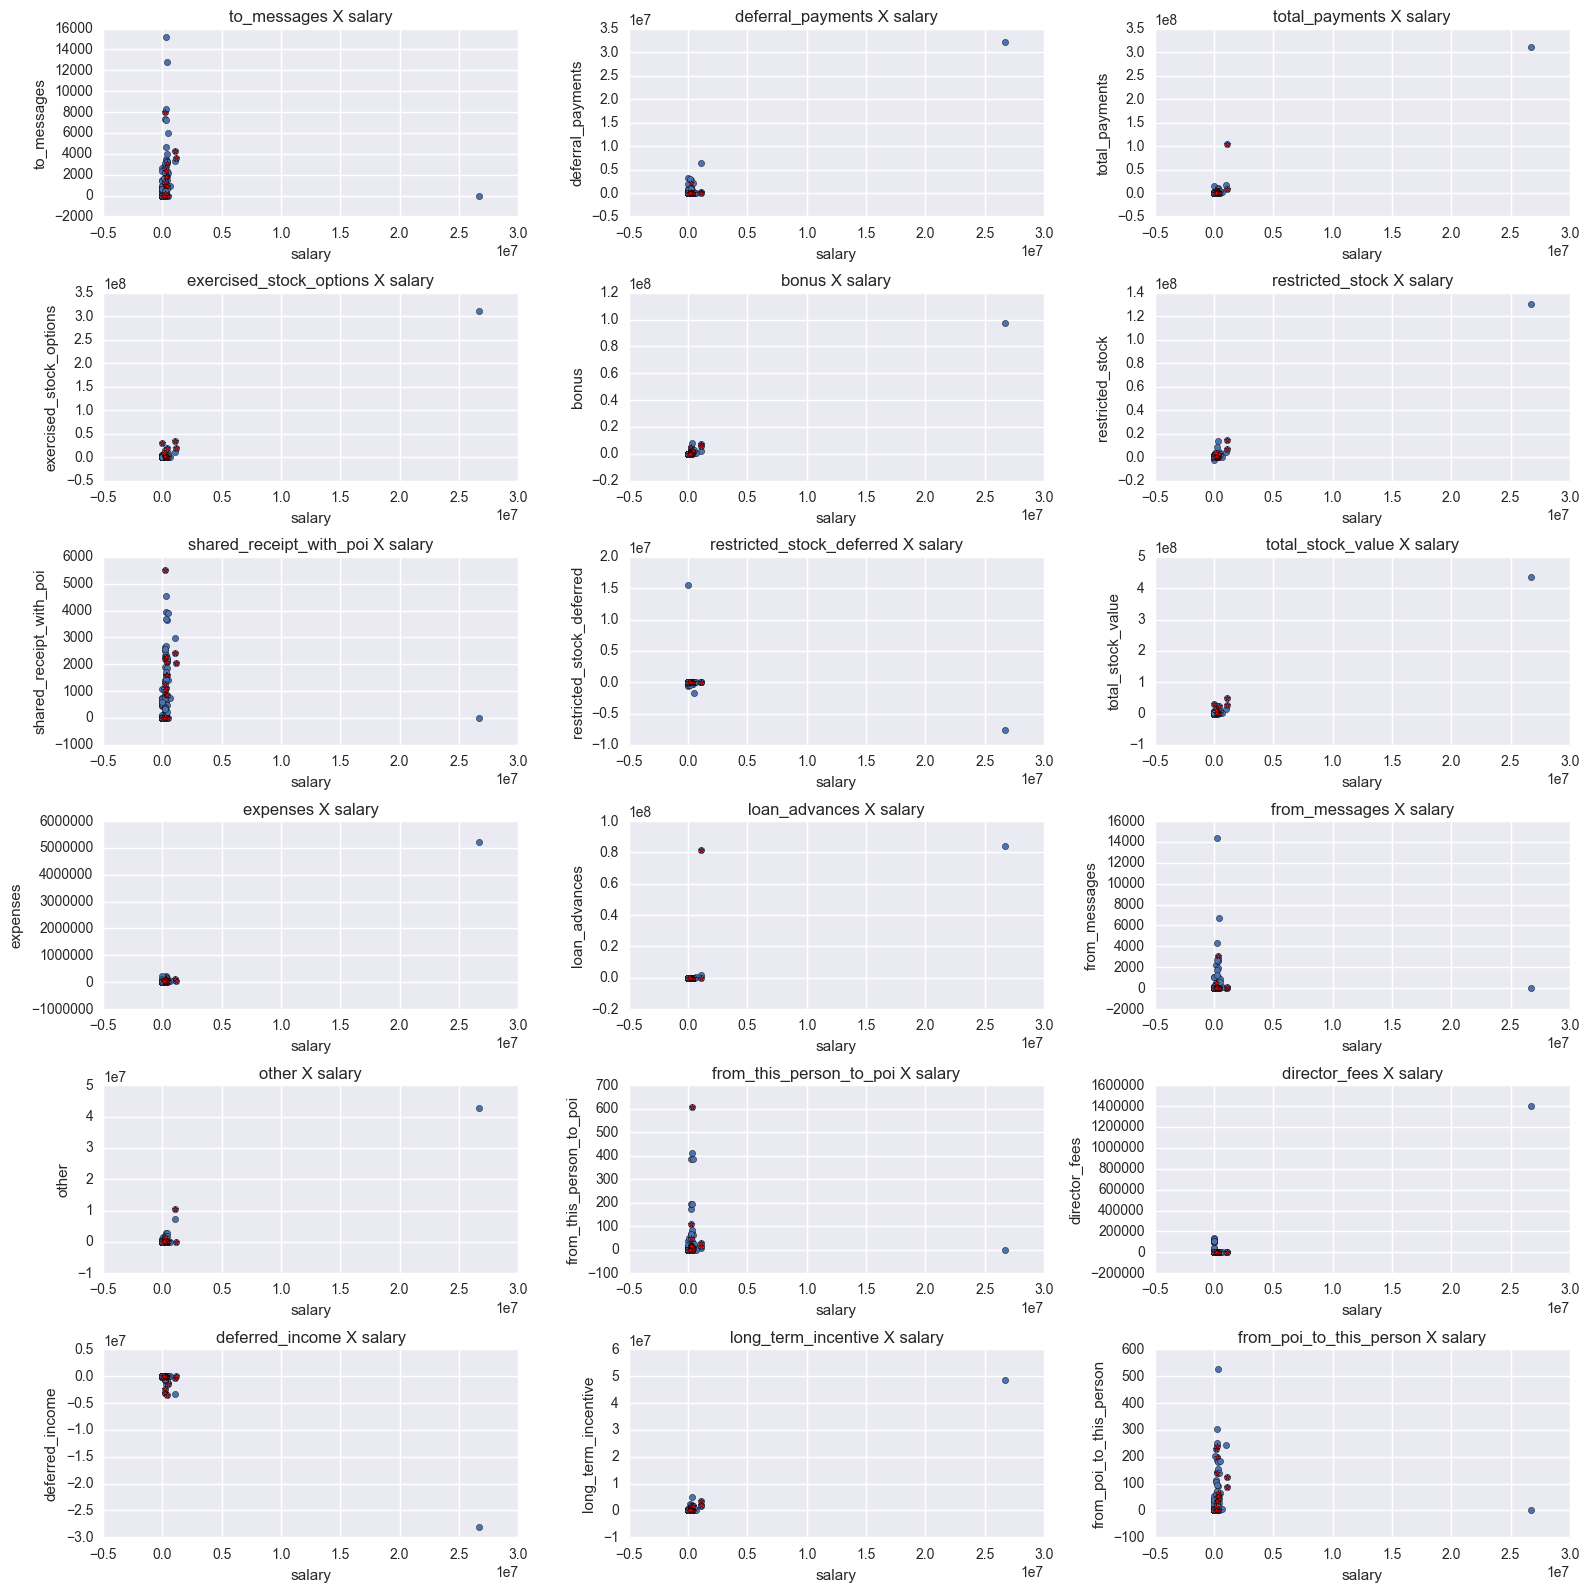

In [408]:
### Replacing NaN's
enron_df.replace(to_replace={'NaN':0}, inplace=True)

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,16))

cols_to_analyse = [x for x in enron_df.columns if x not in ['poi', 'email_address']]

comb_list = []

for i, tp in enumerate(combinations(cols_to_analyse, 2)):
    comb_list.append(tp)
    if tp[0] == 'salary' and tp[1] != 'poi' and tp[1] != 'email_address':
        generate_scatter_plot(tp[0], tp[1], axes[i/3][i%3])

plt.tight_layout()

---
For every combination of features, it is possible to notice a point that is very far from the others.

This point is the **TOTAL** row.

It does not make sense to keep this line through out the analysis.

---

In [409]:
### Removing identified outlier
enron_df.drop('TOTAL', inplace=True)

---
After removing the **TOTAL** row, let's take a look again at how our data is spread.

---

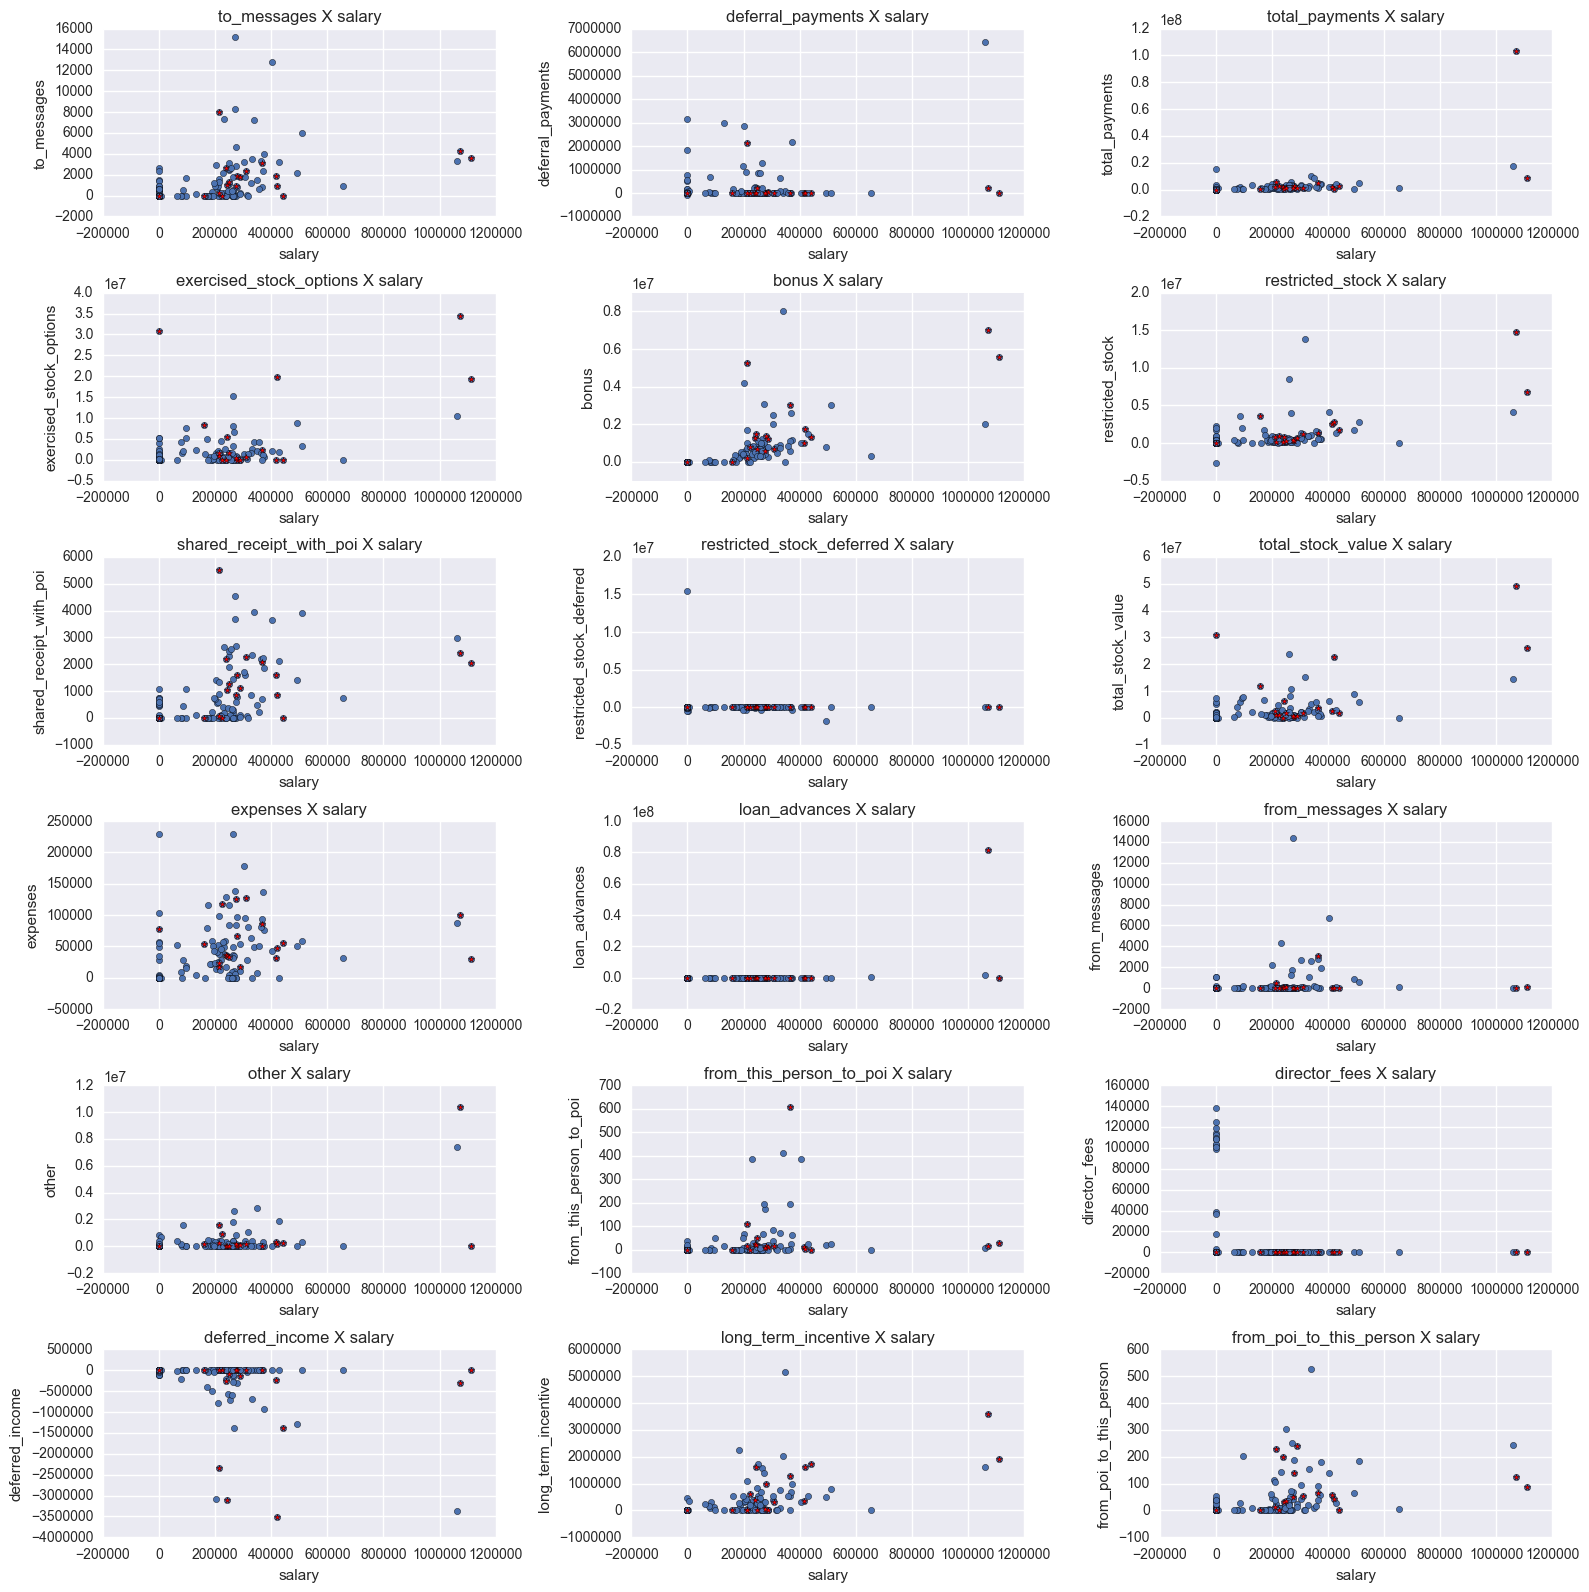

In [410]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,16))

for i, tp in enumerate(comb_list):
    if tp[0] == 'salary' and tp[1] != 'poi' and tp[1] != 'email_address':
        generate_scatter_plot(tp[0], tp[1], axes[i/3][i%3])

plt.tight_layout()

In [411]:
for col in cols_to_analyse:
    threshold = 2*enron_df[col].std()+enron_df[col].mean()
    enron_df.loc[enron_df[col] > threshold, col] = 0

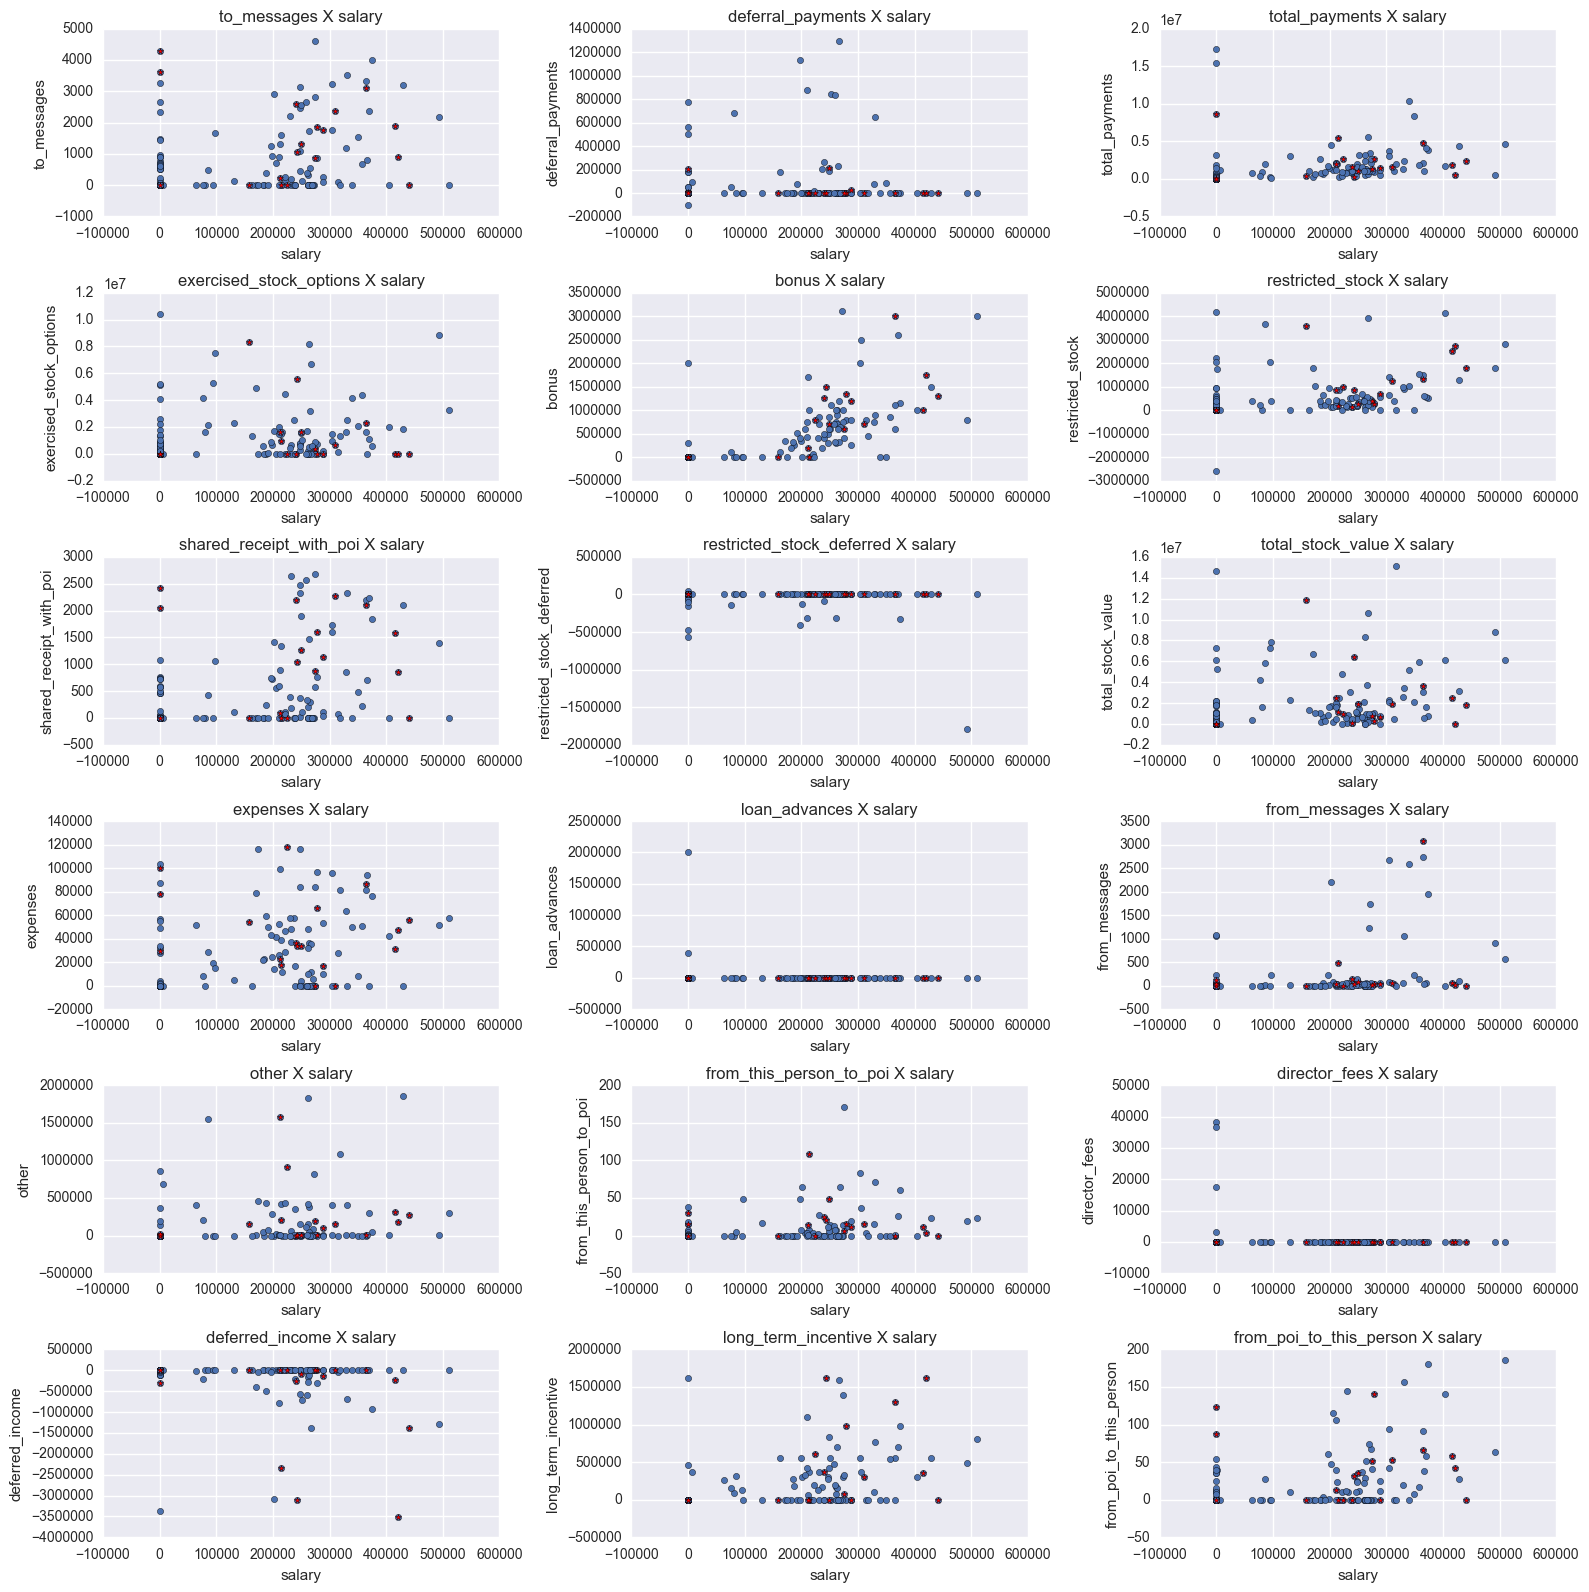

In [412]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,16))

for i, tp in enumerate(comb_list):
    if tp[0] == 'salary' and tp[1] != 'poi' and tp[1] != 'email_address':
        generate_scatter_plot(tp[0], tp[1], axes[i/3][i%3])

plt.tight_layout()

---
-- Explain about data removal

For those plots, we still can see some points that present a different behaviour when compared to the rest of the set.

In the next section, let's do some **Feature Engineering**.

### Feature Engineering

We can try to extract more information from the features that we already have by modifying them in a way that the *Machine Learning* models can have its performance enhanced.

---

In [413]:
display(enron_df[['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi']].head(3))

enron_df['from_poi_percent'] = enron_df['from_poi_to_this_person'] / enron_df['to_messages']
enron_df['to_poi_percent'] = enron_df['from_this_person_to_poi'] / enron_df['from_messages']
enron_df['more_to_than_from'] = np.where(enron_df['to_messages'] / enron_df['from_messages'] > 1, 1, 0)

### Replacing NaN's
for col in ['from_poi_percent','to_poi_percent','more_to_than_from']:
    enron_df.loc[pd.isnull(enron_df[col]), col] = 0
    enron_df.loc[~np.isfinite(enron_df[col]), col] = 0


enron_df[['to_messages', 'from_poi_to_this_person', 'from_poi_percent',\
          'from_messages', 'from_this_person_to_poi', 'to_poi_percent', 'more_to_than_from']].head(3)

,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi
ALLEN PHILLIP K,2902,47,2195,65
BADUM JAMES P,0,0,0,0
BANNANTINE JAMES M,566,39,29,0


,to_messages,from_poi_to_this_person,from_poi_percent,from_messages,from_this_person_to_poi,to_poi_percent,more_to_than_from
ALLEN PHILLIP K,2902,47,0.016196,2195,65,0.029613,1
BADUM JAMES P,0,0,0.000000,0,0,0.000000,0
BANNANTINE JAMES M,566,39,0.068905,29,0,0.000000,1


---
Two variables were created: ***from_poi_percent*** and ***to_poi_percent***.

Both of them present a more precise measure over how each person used to exchange messages with ***POIs***.

---

In [414]:
### Splitting data into Train x Test
from sklearn import cross_validation

enron_df.drop(['email_address'], axis=1, inplace=True)

features = enron_df.drop(['poi'], axis=1)
labels = enron_df['poi']

features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(
    features.values, labels, test_size=0.3, random_state=42)

In [415]:
### Columns with negative values
(enron_df.T < 0).any(1)

salary                       False
to_messages                  False
deferral_payments             True
total_payments               False
exercised_stock_options      False
bonus                        False
restricted_stock              True
shared_receipt_with_poi      False
restricted_stock_deferred     True
total_stock_value             True
expenses                     False
loan_advances                False
from_messages                False
other                        False
from_this_person_to_poi      False
poi                          False
director_fees                False
deferred_income               True
long_term_incentive          False
from_poi_to_this_person      False
from_poi_percent             False
to_poi_percent               False
more_to_than_from            False
dtype: bool

In [416]:
### Dealing with negative values for further use
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

---
### Selecting & Analyzing
Once we made some data engineering, it is time to select which features has better chances to provide interesting results.

To select these variables, I am going to use the ***SelectKBest*** function that is going to extract the best features based on the ***Chi-square*** test.

---

In [427]:
### Task 1: Select what features you'll use.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Number of features to be selected
k = 7

### Creates and fits selector
selector = SelectKBest(chi2, k=k)
selector.fit(features_train, labels_train)

### Get idxs of columns to keep
selected_idx = selector.get_support(indices=True)

### Applies selection over features
features_train_selected = selector.transform(features_train)
features_test_selected = selector.transform(features_test)

columns_list = enron_df[selected_idx].columns.tolist()
columns_list

['to_messages',
 'shared_receipt_with_poi',
 'expenses',
 'other',
 'from_this_person_to_poi',
 'long_term_incentive',
 'from_poi_percent']

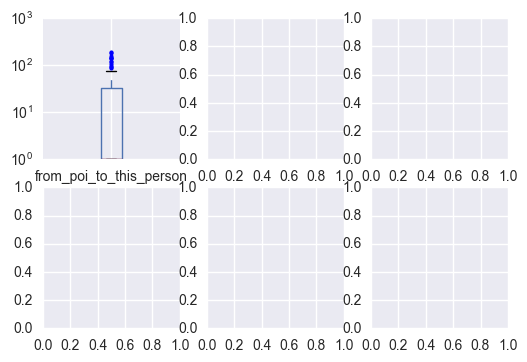

In [240]:
fig, axes = plt.subplots(2, 3)

if 'poi' in columns_list:
    columns_list.remove('poi')
    
for i, x in enumerate(columns_list):
    ax=(enron_df[x]+1).plot(kind='box', ax=axes[i/3][i%3], sym='k.')
    ax.set_yscale('log')

In [313]:
def feature_details(df, feature, top_n=5, quantile=.95):
    col_idx = enron_df.columns.get_loc(feature)
    
    print '-------------------------\n{} score: '.format(feature), selector.scores_[col_idx]
    display(df[[feature, 'poi']].sort_values(by=feature, ascending=False)[:top_n])
    print '{}% of the data are less than or equal to the following value: '.format(quantile*100)\
        ,df[feature].quantile(quantile)

In [420]:
for c in columns_list:
    feature_details(enron_df, c)

-------------------------
shared_receipt_with_poi score:  2.79127161171


,shared_receipt_with_poi,poi
LEFF DANIEL P,2672,False
BECK SALLY W,2639,False
SUNDE MARTIN,2565,False
SHARP VICTORIA T,2477,False
LAY KENNETH L,2411,True


95.0% of the data are less than or equal to the following value:  2262.4
-------------------------
expenses score:  1.99337185208


,expenses,poi
KOPPER MICHAEL J,118134,True
SHARP VICTORIA T,116337,False
KISHKILL JOSEPH G,116335,False
WAKEHAM JOHN,103773,False
LAY KENNETH L,99832,True


95.0% of the data are less than or equal to the following value:  95599.0
-------------------------
from_poi_percent score:  4.40292751397


,from_poi_percent,poi
DEFFNER JOSEPH M,0.161064,False
DURAN WILLIAM D,0.117257,False
UMANOFF ADAM S,0.108108,False
JACKSON CHARLENE R,0.096899,False
CARTER REBECCA C,0.092949,False


95.0% of the data are less than or equal to the following value:  0.0740607895568


---
With the _box plots_ and _tables_ above we can have an idea over how the data from each feature is spread.

Besides that we can see the score that each _feature_ has received (the higher, the best)

### Machine Learning Models

---

In [508]:
### Testing different Machine Learning approaches
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(n_neighbors=5, p=10),
    SVC(kernel="linear", C=.025),
    SVC(C=.0001, gamma=6),
    DecisionTreeClassifier(min_samples_split=2,),
    RandomForestClassifier(n_estimators=4, min_samples_split=5, max_features=2),
    AdaBoostClassifier(n_estimators=5, learning_rate=2, random_state=42),
    GaussianNB()]

### Executing all classifiers over the dataset for later comparison
result = {}
for name, clf in zip(names, classifiers):
    clf.fit(features_train_selected, labels_train)
    
    pred = clf.predict(features_test_selected)
    
    result[name] = {
        'classifier': clf,
        'accuracy_score': accuracy_score(labels_test, pred),
        'precision_score': precision_score(labels_test, pred),
        'recall_score': recall_score(labels_test, pred)
    }

# for k in result.keys():
#     print k
#     print 'Accuracy:',result[k]['accuracy_score']
#     print 'Precision:',result[k]['precision_score']
#     print 'Recall:',result[k]['recall_score']
#     print

clf = result['Decision Tree']['classifier']
my_dataset = enron_df.to_dict(orient='index')
features_list = ['poi'] + columns_list

dump_classifier_and_data(clf, my_dataset, features_list)

In [502]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
clf = result['Decision Tree']['classifier']
my_dataset = enron_df.to_dict(orient='index')
features_list = ['poi'] + columns_list

dump_classifier_and_data(clf, my_dataset, features_list)

---
### Enron Submission Free-Response Questions

1\. **Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]**

 > By using _Machine Learning_ models, it would be possible to identify people who could be involved in frauds. This dataset presents lots of informations related to ***POIs*** and by learning about their behaviour maybe we could identify a pattern and use it classify new data.
 
 > The dataset is full of outliers, but depending on the main goal, we won't remove those from the dataset. The only anomaly that was removed was the **TOTAL** row.


2\. **What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]**

 > The features used were the following:
 - ['salary', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'loan_advances', 'from_poi_to_this_person']
 
 > They were selected using *SelectKBest*.
 
 > Since the dataset presented some features with negative values, I used *MinMaxScaler* so the features could be properly used in the methods.
 
 > Two features were created: *from_poi_percent* and *to_poi_percent*. As mentioned before, these two features would describe how a person and a POI shared information in a more precise way by looking to the proportion of sent and received emails to/from POIs.

3\. **What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]**

4\. **What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]**

 > Tuning the parameters of an algorithm means to change the values of the parameters, experimenting which combinations can provide better results. 

5\. **What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]**

 > 

6\. **Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]**

 > 

---
### References
---

- **Udacity** - https://classroom.udacity.com
- **Scikit-Learn** - http://scikit-learn.org
- **Matplotlib** - https://matplotlib.org/api
- **Pandas** - https://pandas.pydata.org/pandas-docs/stable/index.html
- **Stackoverflow** - https://stackoverflow.com